<a href="https://colab.research.google.com/github/shapirek/DAILY_EXERCISES/blob/main/experimental_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Ссылка на ноутбук:* https://colab.research.google.com/drive/160ioIRFO6TgFMmZhgOj6MsDVOS87GOsu?usp=sharing

## **ЗАГРУЗКА ДАННЫХ**

Data Source: Connection to DB
```
GRANT SELECT ON DATABASE stonk TO yread;
GRANT USAGE ON SCHEMA public TO yread;
GRANT SELECT ON stock_list TO yread;
GRANT SELECT ON av_balance_sheet TO yread;
GRANT SELECT ON av_cash_flow TO yread;
GRANT SELECT ON av_dividends TO yread;
GRANT SELECT ON av_time_series_daily TO yread;
GRANT SELECT ON av_news TO yread;
GRANT SELECT ON av_news_topics TO yread;
```

In [1]:
!pip install plotly

In [2]:
!pip install ta==0.10.2

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import psycopg2
import seaborn as sns
import warnings
import random
from transformers import pipeline
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split

import ta  # технические индикаторы
from ta.trend import MACD, CCIIndicator
from ta.momentum import RSIIndicator, StochasticOscillator
from ta.volatility import BollingerBands
from ta.volume import OnBalanceVolumeIndicator

In [4]:
random.seed(42)
np.random.seed(42)

In [5]:
connection_parameters = {
    "host": "109.167.208.121",
    "database": "stonk",
    "user": "yread",
    "password": "T6cXsjXhB4fw"
}

# функция, принимающая словарь параметров и выполняющая попытку подключения к базе данных
# если подключение успешно, возвращается объект соединения (conn). В случае ошибки, сообщение об ошибке выводится, и программа завершает работу
def connect(params_dic):
    """
    Connect to the PostgreSQL database server
    """
    conn = None
    try:
        conn = psycopg2.connect(**params_dic)
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        sys.exit(1)
    return conn

conn = connect(connection_parameters)

In [6]:
warnings.simplefilter(action='ignore', category=Warning) # отключаем предупреждения

In [7]:
def plot_correlation_heatmap(dataframe, symbol, fig_size):
    filtered_df = dataframe.xs(symbol, level='symbol') # фильтруем по symbol

    correlation_matrix = filtered_df.corr()

    plt.figure(figsize=fig_size)
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True, cbar_kws={"shrink": .8})

    plt.title(f'Тепловая карта корреляций для {symbol}')
    plt.show()

## **ДАННЫЕ OHLC**

*Рассмотрим данные OHLC -- open, high, low, close & volume. Наша задача: добавить новые существенные признаки.*

In [8]:
df_time_series_daily = pd.read_sql_query('select * from av_time_series_daily', conn) # загружаем данные о временных рядах

In [9]:
df_time_series_daily.head() # поглядим на данные

,symbol,daydate,open,high,low,close,volume
0,IBM,2024-10-11,233.25,233.440,230.4600,233.26,3469322
1,IBM,2024-10-10,235.10,235.830,231.8100,233.02,3142031
2,IBM,2024-10-09,229.20,234.950,228.5000,234.30,5083566
3,IBM,2024-10-08,228.11,229.345,227.0401,228.62,3245342
4,IBM,2024-10-07,225.38,227.670,225.0200,227.12,3457952


*Для начала преобразуем признак (или индекс, если данные уже проиндексированы) 'daydate' в формат datetime.*




In [10]:
def convert_daydate_index_to_datetime(df):
    """Преобразует уровень индекса 'daydate' в формат datetime"""
    df.index = df.index.set_levels([df.index.levels[0], pd.to_datetime(df.index.levels[1])])
    return df

def convert_daydate_to_datetime(df):
    """Преобразует признак 'daydate' в формат datetime"""
    df['daydate'] = pd.to_datetime(df['daydate'])
    return df

In [11]:
df_time_series_daily = convert_daydate_to_datetime(df_time_series_daily)

*Можем выделить дополнительные признаки, указывающие на время, когда сделано наблюдение -- year, month, day.*

In [12]:
# если 'daydate' -- индекс
# df_time_series_daily['year'] = df_time_series_daily.index.get_level_values('daydate').year
# df_time_series_daily['month'] = df_time_series_daily.index.get_level_values('daydate').month
# df_time_series_daily['day'] = df_time_series_daily.index.get_level_values('daydate').day

# если 'daydate' -- все еще признак
df_time_series_daily['year'] = df_time_series_daily['daydate'].dt.year
df_time_series_daily['month'] = df_time_series_daily['daydate'].dt.month
df_time_series_daily['day'] = df_time_series_daily['daydate'].dt.day

In [13]:
df_time_series_daily.sample() # посмотрим, все ли хорошо

,symbol,daydate,open,high,low,close,volume,year,month,day
154816,IT,2011-10-27,40.34,41.0,39.76,40.56,502700,2011,10,27


*Добавим новые признаки:*

* **Индикатор RSI:** осциллятор, измеряющий скорость и изменение ценовых движений (принимает значения в диапазоне [0, 100]). Определяет перекупленность (значение выше 70) и перепроданность (значение ниже 30), что позволяет оценить направление тренда.

* **Индикатор MACD:** разница между двумя экспоненциальными скользящими средними. При условии пересечения линии MACD с линией среднего значения MACD можно говорить о смене тренда.

* **Скользящие средние** (например, 20 и 50 периодов): линия среднего значения цены за определенный период.

* **Боллинджерова лента:** несколько полос -- линия средней цены и две другие, которые отражают стандартное отклонение от средней. Этот признак нужен для определения волатильности и перекупленности/перепроданности.

* **Стохастический осциллятор:** осциллятор, сравнивающий закрытие цены с диапазоном цен за определенный период (принимает значения в диапазоне [0, 100]). Тоже сигнализирует о смене тренда и перекупленности/перепроданности. С его помощью можно, кстати, искать точки для входа на рынок.

* **Индикатор CCI:** измеряет отклонение цены от ее статистического среднего значения.

* **Индикатор объема (OnBalanceVolume):** учитывает объемы торгов, добавляя или вычитая объемы в зависимости от направления движения цены. С его помощью можно определять силу/слабость тренда.

In [14]:
def add_technical_indicators(df):
    # индикатор RSI
    rsi_indicator = RSIIndicator(close=df['close'], window=14)
    df['RSI'] = rsi_indicator.rsi()  # Вызов метода .rsi()

    # индикатор MACD
    macd = MACD(close=df['close'])
    df['MACD'] = macd.macd()
    df['MACD_signal'] = macd.macd_signal()

    # скользящие средние
    df['SMA_20'] = df['close'].rolling(window=20).mean()
    df['SMA_50'] = df['close'].rolling(window=50).mean()

    # боллинджерова лента
    bollinger = BollingerBands(close=df['close'], window=20, window_dev=2)
    df['bb_high'] = bollinger.bollinger_hband()
    df['bb_low'] = bollinger.bollinger_lband()
    df['bb_mid'] = bollinger.bollinger_mavg()

    # стохастический осциллятор
    stochastic = StochasticOscillator(
        high=df['high'],
        low=df['low'],
        close=df['close'],
        window=14,
        smooth_window=3
    )
    df['stochastic'] = stochastic.stoch()

    # индикатор CCI
    cci = CCIIndicator(
        high=df['high'],
        low=df['low'],
        close=df['close'],
        window=14
    )
    df['CCI'] = cci.cci()

    # индикатор объема (OnBalanceVolume)
    obv = OnBalanceVolumeIndicator(
        close=df['close'],
        volume=df['volume']
    )
    df['OBV'] = obv.on_balance_volume()

    return df

In [15]:
df_time_series_daily = add_technical_indicators(df_time_series_daily)
# df_time_series_daily = df_time_series_daily.sort_values(by=['symbol', 'daydate']) # сортируем (если нужно)

*Посмотрим на получившийся датасет OHLC*.

In [16]:
# Выводим первые строки для проверки
df_time_series_daily = df_time_series_daily.set_index(['symbol', 'daydate']) # выберем в качестве индексов 'symbol' и 'daydate'
df_time_series_daily = df_time_series_daily.drop(['open', 'high', 'low'], axis = 1) # избавимся от признаков, сильно зависящих от целевой переменной
df_time_series_daily.head()

close   volume  year  month  day  RSI  MACD  MACD_signal  \
symbol daydate                                                                 
IBM    2024-10-11  233.26  3469322  2024     10   11  NaN   NaN          NaN   
       2024-10-10  233.02  3142031  2024     10   10  NaN   NaN          NaN   
       2024-10-09  234.30  5083566  2024     10    9  NaN   NaN          NaN   
       2024-10-08  228.62  3245342  2024     10    8  NaN   NaN          NaN   
       2024-10-07  227.12  3457952  2024     10    7  NaN   NaN          NaN   

                   SMA_20  SMA_50  bb_high  bb_low  bb_mid  stochastic  CCI  \
symbol daydate                                                                
IBM    2024-10-11     NaN     NaN      NaN     NaN     NaN         NaN  NaN   
       2024-10-10     NaN     NaN      NaN     NaN     NaN         NaN  NaN   
       2024-10-09     NaN     NaN      NaN     NaN     NaN         NaN  NaN   
       2024-10-08     NaN     NaN      NaN     NaN     NaN         NaN  NaN   
       2024-10-07     NaN     NaN      NaN     NaN     NaN         NaN  NaN   

                       OBV  
symbol daydate              
IBM    2024-10-11  3469322  
       2024-10-10   327291  
       2024-10-09  5410857  
       2024-10-08  2165515  
       2024-10-07 -1292437

## **НОВОСТИ**

*Загрузим новостные данные.*

In [17]:
df_av_news = pd.read_sql_query('select  * from av_news', conn)
df_av_news.set_index(['time_published','symbol'])

df_av_news['time_published'] = pd.to_datetime(df_av_news['time_published'])

In [18]:
df_av_news.head()

,id,title,url,time_published,authors,summary,banner_image,source,category_within_source,source_domain,overall_sentiment_score,overall_sentiment_label,symbol
0,1,Cognizant Set to Report Q3 Earnings: What''s i...,https://www.zacks.com/stock/news/2358933/cogni...,2024-10-28 17:32:00+00:00,Zacks Investment Research,CTSH''s third-quarter performance is likely to...,https://staticx-tuner.zacks.com/images/article...,Zacks Commentary,n/a,www.zacks.com,0.291579,Somewhat-Bullish,CTSH
1,2,DoorDash Set to Report Q3 Earnings: What''s in...,https://www.zacks.com/stock/news/2358925/doord...,2024-10-28 17:21:00+00:00,Zacks Investment Research,DASH''s third-quarter 2024 results are likely ...,https://staticx-tuner.zacks.com/images/article...,Zacks Commentary,n/a,www.zacks.com,0.317762,Somewhat-Bullish,CTSH
2,3,Twilio Gears Up to Report Q3 Earnings: What''s...,https://www.zacks.com/stock/news/2358775/twili...,2024-10-28 13:53:00+00:00,Zacks Equity Research,TWLO''s Q3 results are likely to reflect benef...,https://staticx-tuner.zacks.com/images/article...,Zacks Commentary,n/a,www.zacks.com,0.191054,Somewhat-Bullish,CTSH
3,4,Booking Holdings to Report Q3 Earnings: What''...,https://www.zacks.com/stock/news/2358746/booki...,2024-10-28 13:18:00+00:00,Zacks Equity Research,BKNG''s third-quarter 2024 results are likely ...,https://staticx-tuner.zacks.com/images/article...,Zacks Commentary,n/a,www.zacks.com,0.216338,Somewhat-Bullish,CTSH
4,5,F5 Gears Up to Report Q4 Earnings: What''s in ...,https://www.zacks.com/stock/news/2357954/f5-ge...,2024-10-25 14:54:00+00:00,Zacks Equity Research,FFIV''s fourth-quarter fiscal 2024 results are...,https://staticx-tuner.zacks.com/images/article...,Zacks Commentary,n/a,www.zacks.com,0.113492,Neutral,CTSH


*Теперь добавим новые признаки, указывающие на то, когда новость была опубликована -- с точностью до секунды. Заметим, что может быть несколько новостей в один день.*

In [19]:
# колонка со временем
df_av_news['time'] = df_av_news['time_published'].dt.strftime('%H:%M:%S%z')

# колонка с датой в формате datetime
df_av_news['daydate'] = df_av_news['time_published'].dt.date  # сохраняем как дату

def process_time_column(df):
    df['time'] = df['time'].str.split('+').str[0]

    df['hour'] = df['time'].str.split(':').str[0].astype(int)

    df['minute'] = df['time'].str.split(':').str[1].astype(int)

    df['sec'] = df['time'].str.split(':').str[2].astype(int)

    return df

processed_df = process_time_column(df_av_news)
df_av_news = processed_df.drop('time', axis=1)

# 'daydate' в формате datetime
df_av_news['daydate'] = pd.to_datetime(df_av_news['daydate'])

In [20]:
df_av_news = df_av_news.drop(['time_published', 'id'], axis = 1) # удаляем технические и ненужные теперь признаки
df_av_news['category_within_source'] = df_av_news['category_within_source'].replace('n/a', np.nan) # заменяем n/a на NaN в колонке category_within_source
df_av_news = df_av_news.set_index(['symbol', 'daydate']) # индексируем

*Посмотрим теперь на наш новостной датасет.*

In [21]:
df_av_news.head(2)

title  \
symbol daydate                                                         
CTSH   2024-10-28  Cognizant Set to Report Q3 Earnings: What''s i...   
       2024-10-28  DoorDash Set to Report Q3 Earnings: What''s in...   

                                                                 url  \
symbol daydate                                                         
CTSH   2024-10-28  https://www.zacks.com/stock/news/2358933/cogni...   
       2024-10-28  https://www.zacks.com/stock/news/2358925/doord...   

                                     authors  \
symbol daydate                                 
CTSH   2024-10-28  Zacks Investment Research   
       2024-10-28  Zacks Investment Research   

                                                             summary  \
symbol daydate                                                         
CTSH   2024-10-28  CTSH''s third-quarter performance is likely to...   
       2024-10-28  DASH''s third-quarter 2024 results are likely ...   

                                                        banner_image  \
symbol daydate                                                         
CTSH   2024-10-28  https://staticx-tuner.zacks.com/images/article...   
       2024-10-28  https://staticx-tuner.zacks.com/images/article...   

                             source category_within_source  source_domain  \
symbol daydate                                                              
CTSH   2024-10-28  Zacks Commentary                    NaN  www.zacks.com   
       2024-10-28  Zacks Commentary                    NaN  www.zacks.com   

                   overall_sentiment_score overall_sentiment_label  hour  \
symbol daydate                                                             
CTSH   2024-10-28                 0.291579        Somewhat-Bullish    17   
       2024-10-28                 0.317762        Somewhat-Bullish    17   

                   minute  sec  
symbol daydate                  
CTSH   2024-10-28      32    0  
       2024-10-28      21    0

*Заметим, что в нашем датасете уже реализован sentiment analysis, однако, мы не знаем наверняка, насколько он качественный. Поэтому мы проведем еще один, независимый анализ -- в этот раз используем FinBERT. Если вы включаете код в ноутбуке, не забудьте про ускоритель GPU -- иначе придется долго ждать.*

In [22]:
# загружаем модель
finbert = pipeline("sentiment-analysis", model="ProsusAI/finbert")

# функция для получения настроения по объединённому тексту из title и summary
def get_finbert_sentiment(row):
    # объединяем текст из двух признаков (приводим к строковому типу, на случай пустых значений)
    text = str(row['summary'])
    # получаем результат (например: {'label': 'NEGATIVE', 'score': 0.87})
    result = finbert(text)[0]
    # можно вернуть как оценку, так и сам label – здесь возвращаем score
    return result['score']

# применяем функцию к каждой строке датасета
df_av_news['finbert_sentiment'] = df_av_news.apply(get_finbert_sentiment, axis=1)

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


***Замечание из будущего:*** *sentiment analysis, вкрапленный внутрь новостного датасета, и тот, что предложен моделью FinBERT, отличаются (у них слабая линейная корреляция). Причем для некоторых акций лучшие результаты (в том смысле, что они сильнее коррелируют с целевой переменной) показывает FinBERT, для некоторых -- дефолтный sentiment analysis.*

*Мы обработали OHLC и новостной датасеты, добавили новые признаки -- и теперь готовы объединить датасеты!*

## **ОБЪЕДИНЕНИЕ ДАННЫХ**

*Прежде всего подготовим новостные данные к объединению -- т.к. в один день может быть несколько новостей, то мы объединим новости по дням (и заодно добавим еще несколько новых признаков).*

In [23]:
# преобразуем признаки времени в единое значение (например, создаём timedelta)
df_av_news['time'] = pd.to_timedelta(df_av_news['hour'], unit='h') + \
                  pd.to_timedelta(df_av_news['minute'], unit='m') + \
                  pd.to_timedelta(df_av_news['sec'], unit='s')

*Новый признак будет показывать динамику настроений новостей в пределах дня.*

In [24]:
# динамика настроения в пределах дня
def calc_sentiment_dynamics(group):
    group_sorted = group.sort_values(by='time')
    # вычисляем разницу между последовательными значениями overall_sentiment_score
    diffs = group_sorted['overall_sentiment_score'].diff().dropna()
    if diffs.empty:
        return 0.0
    else:
        return diffs.mean()

In [25]:
# группируем данные по мультииндексу (symbol, daydate)
grouped = df_av_news.groupby(level=[0, 1])

# агрегируем нужные признаки
agg_df = grouped.agg(
    news_count = ('title', 'count'),
    avg_overall_sentiment = ('overall_sentiment_score', 'mean'),
    unique_source_count = ('source_domain', 'nunique'),
    avg_finbert_sentiment = ('finbert_sentiment', 'mean')
)

# вычисляем динамику настроения для каждой группы
dynamics_series = grouped.apply(calc_sentiment_dynamics)
dynamics_series.name = "avg_sentiment_dynamics"

# объединяем агрегированные данные с динамикой
agg_df = agg_df.join(dynamics_series)

*Теперь наконец-то объединим датасеты!*

In [26]:
# объединяем агрегированный датасет с df_time_series_daily по мультииндексу (symbol, daydate)
df_final = pd.merge(df_time_series_daily, agg_df, left_index=True, right_index=True, how='left')

*Исследуем данные на предмет пропущенных значений.*

---



### **Первый подход**: *удаляем все пропуски*

In [27]:
df_union = df_final.copy()
df_union = df_union.dropna()

In [28]:
df_union.shape

(7277, 21)

*После удаления всех наблюдений с пропусками осталось всего ~7200 наблюдений (из почти 200000), что, очевидно, очень мало -- но мы проверим, насколько хорошо справляются модели и на таких небольших данных.*

*Посмотрим, кстати, насколько оправдано было добавление новых признаков -- и какая модель sentiment анализа показывает лучшие результаты.*

In [29]:
unique_symbols = df_union.index.get_level_values('symbol').unique()
print("Уникальные символы:", unique_symbols)

Уникальные символы: Index(['IBM', 'CLVT', 'CTSH', 'TTEC', 'DMRC', 'ASGN', 'MGIC', 'SAIC', 'LDOS',
       'ACN', 'BTCM', 'III', 'HCKT', 'IBEX', 'CTLP', 'NABL', 'GIB', 'GDS',
       'INOD', 'JDZG', 'GMM', 'CNDT', 'TWKS', 'ARBB', 'WNS', 'BBAI', 'G',
       'JFU', 'VNET', 'EXLS', 'NYAX', 'CSPI', 'GLOB', 'BR', 'INFY', 'GDYN',
       'CNXC', 'DTST', 'XRX', 'SAIH', 'IT', 'CACI', 'WIT', 'KD', 'APLD', 'CDW',
       'UIS', 'AIFF', 'AUR', 'NOTE', 'EPAM', 'JKHY', 'DXC', 'FIS'],
      dtype='object', name='symbol')


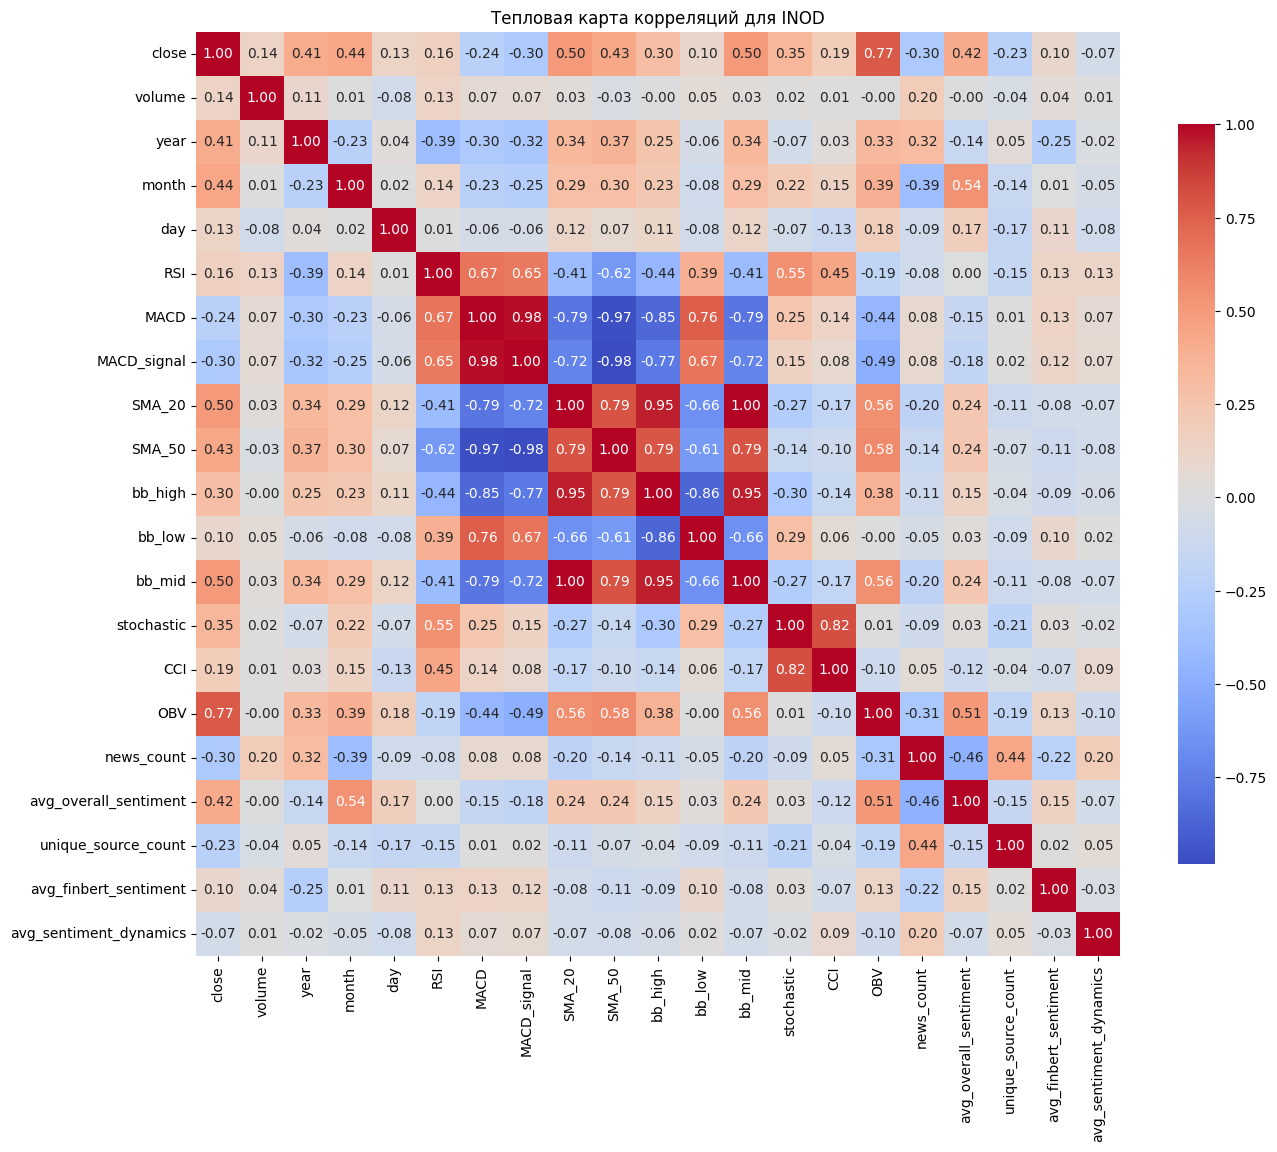

In [30]:
plot_correlation_heatmap(df_union, 'INOD', (15, 12))

### **Второй подход**: *заполняем пропуски средними арифметическими*

In [31]:
df_final.sample(3)

,,close,volume,year,month,day,RSI,MACD,MACD_signal,SMA_20,SMA_50,...,bb_low,bb_mid,stochastic,CCI,OBV,news_count,avg_overall_sentiment,unique_source_count,avg_finbert_sentiment,avg_sentiment_dynamics
symbol,daydate,,,,,,,,,,,,,,,,,,,,,
CACI,2007-03-09,47.73,272700,2007,3,9,47.699419,-0.421276,-0.173335,48.2375,48.1190,...,44.375910,48.2375,27.201258,-35.311030,-2124887457,NaN,NaN,NaN,NaN,NaN
HCKT,2014-01-15,6.09,66700,2014,1,15,56.602715,0.018447,-0.003754,5.9535,5.9974,...,5.795478,5.9535,71.739130,47.602147,-1367341871,NaN,NaN,NaN,NaN,NaN
KD,2024-02-29,21.97,1767144,2024,2,29,42.479857,-1.874661,-2.452995,22.7655,30.4406,...,17.117575,22.7655,79.899497,66.379219,-1976012377,NaN,NaN,NaN,NaN,NaN


In [32]:
# список символов, которые есть в обоих датафреймах
common_symbols = df_final.index.get_level_values('symbol').unique().intersection(
    df_av_news.index.get_level_values('symbol').unique()
)

# фильтруем df_final, оставляя только строки с символами из пересечения
df_skip = df_final[df_final.index.get_level_values('symbol').isin(common_symbols)].copy()

*Посмотрим, сколько пропусков в данных.*

In [33]:
df_skip.isna().sum()

,0
close,0
volume,0
year,0
month,0
day,0
RSI,13
MACD,25
MACD_signal,33
SMA_20,19
SMA_50,49


*Заполним каждый пропуск (или набор пропусков) средним арифметическим ближайших к этому пропуску (или набору пропусков) значений.*

In [34]:
def fill_gap(series):
    filled = series.copy()
    fwd = series.ffill()
    bwd = series.bfill()

    # Для каждой позиции, где исходное значение NaN и с обеих сторон есть реальные значения, заполняем пропуск средним арифметическим
    mask = series.isna() & fwd.notna() & bwd.notna()
    filled[mask] = (fwd[mask] + bwd[mask]) / 2
    return filled

In [35]:
# определяем признаки с пропусками
na_columns = df_skip.columns[df_skip.isna().any()]

# для каждого признака применяем функцию fill_gap по символу
for col in na_columns:
    df_skip[col] = df_skip.groupby(level='symbol')[col].transform(fill_gap)

*Проверим, сколько пропусков мы так заполнили.*

In [36]:
df_skip.isna().sum()

,0
close,0
volume,0
year,0
month,0
day,0
RSI,13
MACD,25
MACD_signal,33
SMA_20,19
SMA_50,49


*Заметим, что мы таким образом заполнили больше 120000 наблюдений с пропусками. Посмотрим, насколько увеличатся показатели моделей (если вообще увеличатся).*

#### Вариант 1: *Удалим оставшиеся пропуски*

In [37]:
df_combo = df_skip.copy()
df_skip = df_skip.dropna()

In [38]:
df_skip.isna().sum()

,0
close,0
volume,0
year,0
month,0
day,0
RSI,0
MACD,0
MACD_signal,0
SMA_20,0
SMA_50,0


In [52]:
df_skip.shape

(129325, 21)

#### Вариант 2: *Заполним оставшиеся пропуски предсказаниями какой-нибудь модели*

In [39]:
from sklearn.ensemble import ExtraTreesRegressor

df = df_combo.copy()

multi_index = df.index
df_reset = df.reset_index()

# определяем столбцы для иммутации: исключаем мультииндексные столбцы (symbol, daydate) и, если есть, служебные (например, 'level_0', 'index')
cols_to_use = df_reset.columns.difference(['symbol', 'daydate', 'level_0', 'index'])

# определяем список столбцов, в которых есть пропуски, и упорядочиваем их по доле пропусков (от меньшей к большей)
cols_with_missing = [col for col in cols_to_use if df_reset[col].isnull().any()]
cols_with_missing = sorted(cols_with_missing, key=lambda c: df_reset[c].isnull().mean())

# задаем порог корреляции и минимальное число наблюдений для расчёта корреляции
corr_threshold = 0.2
min_samples = 30

for col in cols_with_missing:
    print(f"Импутируем столбец: {col}")

    not_missing = df_reset[col].notnull()
    missing = df_reset[col].isnull()

    # в качестве кандидатов для предикторов используем все остальные столбцы из cols_to_use
    candidate_predictors = [c for c in cols_to_use if c != col]
    selected_predictors = []

    # выбираем те признаки, которые достаточно коррелируют с целевым столбцом (на строках, где оба признака не пропущены)
    for pred in candidate_predictors:
        common = df_reset[not_missing & df_reset[pred].notnull()]
        if common.shape[0] < min_samples:
            continue
        corr_value = common[col].corr(common[pred])
        if pd.notnull(corr_value) and np.abs(corr_value) >= corr_threshold:
            selected_predictors.append(pred)

    print(f"Выбраны предикторы для {col}: {selected_predictors}")

    if len(selected_predictors) == 0:
        # если подходящих предикторов нет, заполним медианой
        median_val = df_reset.loc[not_missing, col].median()
        df_reset.loc[missing, col] = median_val
        print(f"Нет предикторов, удовлетворяющих порогу; заполнено медианой: {median_val}\n")
    else:
        # формируем обучающую выборку для строк без пропусков в col
        X_train = df_reset.loc[not_missing, selected_predictors]
        y_train = df_reset.loc[not_missing, col]

        # заполняем пропуски в предикторах медианными значениями (вычисляем медиану по X_train)
        medians = X_train.median()
        X_train_filled = X_train.fillna(medians)

        # готовим данные для предсказания: строки, где в col пропуски
        X_pred = df_reset.loc[missing, selected_predictors].fillna(medians)

        # обучаем модель ExtraTreesRegressor (число деревьев можно уменьшить для экономии памяти)
        model = ExtraTreesRegressor(n_estimators=50, random_state=42)
        model.fit(X_train_filled, y_train)

        # делаем предсказание для пропусков и заполняем их
        pred_values = model.predict(X_pred)
        df_reset.loc[missing, col] = pred_values
        print(f"Заполнено {missing.sum()} пропусков в {col} с помощью ExtraTreesRegressor.\n")

df_combo = df_reset.set_index(['symbol', 'daydate'])

Импутируем столбец: CCI
Выбраны предикторы для CCI: ['RSI', 'stochastic']
Заполнено 13 пропусков в CCI с помощью ExtraTreesRegressor.

Импутируем столбец: RSI
Выбраны предикторы для RSI: ['CCI', 'MACD', 'MACD_signal', 'stochastic']
Заполнено 13 пропусков в RSI с помощью ExtraTreesRegressor.

Импутируем столбец: stochastic
Выбраны предикторы для stochastic: ['CCI', 'RSI']
Заполнено 13 пропусков в stochastic с помощью ExtraTreesRegressor.

Импутируем столбец: SMA_20
Выбраны предикторы для SMA_20: ['SMA_50', 'bb_high', 'bb_low', 'bb_mid', 'close', 'year']
Заполнено 19 пропусков в SMA_20 с помощью ExtraTreesRegressor.

Импутируем столбец: bb_high
Выбраны предикторы для bb_high: ['MACD_signal', 'SMA_20', 'SMA_50', 'bb_low', 'bb_mid', 'close', 'year']
Заполнено 19 пропусков в bb_high с помощью ExtraTreesRegressor.

Импутируем столбец: bb_low
Выбраны предикторы для bb_low: ['SMA_20', 'SMA_50', 'bb_high', 'bb_mid', 'close', 'year']
Заполнено 19 пропусков в bb_low с помощью ExtraTreesRegressor.

*Проверим!*

In [40]:
df_combo.isna().sum()

,0
close,0
volume,0
year,0
month,0
day,0
RSI,0
MACD,0
MACD_signal,0
SMA_20,0
SMA_50,0


### **Третий подход**: *научим модель предсказывать пропуски*

In [47]:
from sklearn.ensemble import ExtraTreesRegressor

df_mage = df_final.copy()

multi_index = df.index
df_reset = df.reset_index()

# определяем столбцы для иммутации: исключаем мультииндексные столбцы (symbol, daydate) и, если есть, служебные (например, 'level_0', 'index')
cols_to_use = df_reset.columns.difference(['symbol', 'daydate', 'level_0', 'index'])

# определяем список столбцов, в которых есть пропуски, и упорядочиваем их по доле пропусков (от меньшей к большей)
cols_with_missing = [col for col in cols_to_use if df_reset[col].isnull().any()]
cols_with_missing = sorted(cols_with_missing, key=lambda c: df_reset[c].isnull().mean())

# задаем порог корреляции и минимальное число наблюдений для расчёта корреляции
corr_threshold = 0.2
min_samples = 30

for col in cols_with_missing:
    print(f"Импутируем столбец: {col}")

    not_missing = df_reset[col].notnull()
    missing = df_reset[col].isnull()

    # в качестве кандидатов для предикторов используем все остальные столбцы из cols_to_use
    candidate_predictors = [c for c in cols_to_use if c != col]
    selected_predictors = []

    # выбираем те признаки, которые достаточно коррелируют с целевым столбцом (на строках, где оба признака не пропущены)
    for pred in candidate_predictors:
        common = df_reset[not_missing & df_reset[pred].notnull()]
        if common.shape[0] < min_samples:
            continue
        corr_value = common[col].corr(common[pred])
        if pd.notnull(corr_value) and np.abs(corr_value) >= corr_threshold:
            selected_predictors.append(pred)

    print(f"Выбраны предикторы для {col}: {selected_predictors}")

    if len(selected_predictors) == 0:
        # если подходящих предикторов нет, заполним медианой
        median_val = df_reset.loc[not_missing, col].median()
        df_reset.loc[missing, col] = median_val
        print(f"Нет предикторов, удовлетворяющих порогу; заполнено медианой: {median_val}\n")
    else:
        # формируем обучающую выборку для строк без пропусков в col
        X_train = df_reset.loc[not_missing, selected_predictors]
        y_train = df_reset.loc[not_missing, col]

        # заполняем пропуски в предикторах медианными значениями (вычисляем медиану по X_train)
        medians = X_train.median()
        X_train_filled = X_train.fillna(medians)

        # готовим данные для предсказания: строки, где в col пропуски
        X_pred = df_reset.loc[missing, selected_predictors].fillna(medians)

        # обучаем модель ExtraTreesRegressor (число деревьев можно уменьшить для экономии памяти)
        model = ExtraTreesRegressor(n_estimators=50, random_state=42)
        model.fit(X_train_filled, y_train)

        # делаем предсказание для пропусков и заполняем их
        pred_values = model.predict(X_pred)
        df_reset.loc[missing, col] = pred_values
        print(f"Заполнено {missing.sum()} пропусков в {col} с помощью ExtraTreesRegressor.\n")

df_mage = df_reset.set_index(['symbol', 'daydate'])

Импутируем столбец: CCI
Выбраны предикторы для CCI: ['RSI', 'stochastic']
Заполнено 13 пропусков в CCI с помощью ExtraTreesRegressor.

Импутируем столбец: RSI
Выбраны предикторы для RSI: ['CCI', 'MACD', 'MACD_signal', 'stochastic']
Заполнено 13 пропусков в RSI с помощью ExtraTreesRegressor.

Импутируем столбец: stochastic
Выбраны предикторы для stochastic: ['CCI', 'RSI']
Заполнено 13 пропусков в stochastic с помощью ExtraTreesRegressor.

Импутируем столбец: SMA_20
Выбраны предикторы для SMA_20: ['SMA_50', 'bb_high', 'bb_low', 'bb_mid', 'close', 'year']
Заполнено 19 пропусков в SMA_20 с помощью ExtraTreesRegressor.

Импутируем столбец: bb_high
Выбраны предикторы для bb_high: ['MACD_signal', 'SMA_20', 'SMA_50', 'bb_low', 'bb_mid', 'close', 'year']
Заполнено 19 пропусков в bb_high с помощью ExtraTreesRegressor.

Импутируем столбец: bb_low
Выбраны предикторы для bb_low: ['SMA_20', 'SMA_50', 'bb_high', 'bb_mid', 'close', 'year']
Заполнено 19 пропусков в bb_low с помощью ExtraTreesRegressor.

## **МОДЕЛИ**

### Baseline

In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math


class RegressionModel(BaseEstimator, TransformerMixin):
    def __init__(self, symbol, parameter='close', start_date=None, end_date=None, forecast_days = 7):
        self.symbol = symbol
        self.parameter = parameter
        self.start_date = start_date
        self.end_date = end_date
        self.model = LinearRegression()
        self.train_data = None
        self.test_data = None
        self.forecast_days = forecast_days

    def prepare_data_smoothing(self, df):
        df_filtered = df.xs(self.symbol, level=0)

        # сортируем временную ось по возрастанию
        df_filtered.sort_index(inplace=True)

        if self.start_date:
            df_filtered = df_filtered[df_filtered.index >= self.start_date]
        if self.end_date:
            df_filtered = df_filtered[df_filtered.index <= self.end_date]

        df_filtered['log_price'] = np.log(df_filtered[self.parameter])
        df_filtered['exp_smoothing'] = df_filtered['log_price'].ewm(span=12, adjust=False).mean()
        df_filtered = df_filtered.dropna()

        return df_filtered

    def fit(self, df, y=None):
        df_filtered = self.prepare_data_smoothing(df)

        # определяем последнюю дату в данных и вычисляем дату начала тестового периода
        max_date = df_filtered.index.max()
        test_start_date = max_date - pd.Timedelta(days=self.forecast_days - 1)

        # тестовая выборка – данные за последние forecast_days дней
        self.test_data = df_filtered[df_filtered.index >= test_start_date]

        # тренировочная выборка – все данные до тестового периода
        train_data = df_filtered[df_filtered.index < test_start_date]

        # TimeSeriesSplit для кросс-валидации на тренировочных данных
        from sklearn.model_selection import TimeSeriesSplit
        tscv = TimeSeriesSplit(n_splits=3)
        cv_scores = []
        for fold, (train_index, val_index) in enumerate(tscv.split(train_data), 1):
            cv_train = train_data.iloc[train_index]
            cv_val = train_data.iloc[val_index]
            self.model.fit(cv_train[['exp_smoothing']], cv_train['log_price'])
            val_pred = self.model.predict(cv_val[['exp_smoothing']])
            mse_cv = mean_squared_error(cv_val['log_price'], val_pred)
            cv_scores.append(mse_cv)
            print(f"Fold {fold} MSE: {mse_cv}")

        print(f"Среднее CV MSE: {np.mean(cv_scores)}")

        self.train_data = train_data
        self.model.fit(self.train_data[['exp_smoothing']], self.train_data['log_price'])

        return self

    def transform(self, df):
        df_filtered = self.prepare_data_smoothing(df)
        test_data = df_filtered[-len(self.test_data):].copy()
        pred_deterministic = self.model.predict(test_data[['exp_smoothing']])

        # вычисляем стандартное отклонение ошибок на тренировочных данных
        train_pred = self.model.predict(self.train_data[['exp_smoothing']])
        train_residuals = self.train_data['log_price'] - train_pred
        resid_std = np.std(train_residuals)

        forecast_length = len(pred_deterministic)
        factor = 2  # конечное увеличение стандартного отклонения на горизонте прогноза
        # линейное нарастание: от resid_std до resid_std*factor
        sigma_by_lag = resid_std * (1 + (np.arange(forecast_length) / (forecast_length - 1)) * (factor - 1))

        # определяем число прогнозных выборок для вероятностного прогноза (например, 100)
        n_samples = 100

        # генерация прогнозных выборок
        # для каждого шага добавляем шум, где std для i-го шага = sigma_by_lag[i]
        predictions_samples = np.array([
            pred_deterministic + np.random.normal(0, sigma_by_lag)
            for _ in range(n_samples)
        ])

        # визуализация
        self.plot_results(self.train_data, test_data, predictions_samples)

        median_pred = np.median(predictions_samples, axis=0)
        mse = mean_squared_error(test_data['log_price'], median_pred)
        mae = mean_absolute_error(test_data['log_price'], median_pred)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs(median_pred - test_data['log_price']) / np.abs(test_data['log_price']))
        r2 = r2_score(test_data['log_price'], median_pred)

        print(f'MSE: {mse}')
        print(f'MAE: {mae}')
        print(f'RMSE: {rmse}')
        print(f'MAPE: {mape}')
        print(f'R2: {r2}')

        return predictions_samples


    def plot_results(self, train_data, test_data, predictions_samples):

        # прогноз (медиана) и квантильные интервалы по прогнозным выборкам:
        pred_mean = np.median(predictions_samples, axis=0)
        lower_95 = np.percentile(predictions_samples, 2.5, axis=0)
        upper_95 = np.percentile(predictions_samples, 97.5, axis=0)
        lower_50 = np.percentile(predictions_samples, 25, axis=0)
        upper_50 = np.percentile(predictions_samples, 75, axis=0)

        # используем индекс тестового набора как ось прогноза
        forecast_index = test_data.index
        predicted_series = pd.Series(pred_mean, index=forecast_index)

        fig = go.Figure()

        # тренировочные данные (логарифм цены)
        fig.add_trace(go.Scatter(
            x=train_data.index,
            y=train_data['log_price'],
            mode='lines',
            name='Train Data Log Price',
            line=dict(color='blue')
        ))

        # экспоненциальное сглаживание для тренировочных данных
        fig.add_trace(go.Scatter(
            x=train_data.index,
            y=train_data['exp_smoothing'],
            mode='lines',
            name='Exponential Smoothing (Train)',
            line=dict(dash='dash', color='purple')
        ))

        # тестовые данные (фактический логарифм цены)
        fig.add_trace(go.Scatter(
            x=test_data.index,
            y=test_data['log_price'],
            mode='lines',
            name='Test Data Log Price',
            line=dict(color='green')
        ))

        # прогнозируемая медиана
        fig.add_trace(go.Scatter(
            x=predicted_series.index,
            y=predicted_series,
            mode='lines',
            name='Predicted Log Price (Median)',
            line=dict(color='red')
        ))

        # 95%-й доверительный интервал (заполненная область)
        fig.add_trace(go.Scatter(
            x=list(forecast_index) + list(forecast_index[::-1]),
            y=list(upper_95) + list(lower_95[::-1]),
            fill='toself',
            fillcolor='rgba(255,182,193,0.3)',  # светло-розовый
            line=dict(color='rgba(255,255,255,0)'),
            hoverinfo="skip",
            name='95% Prediction Interval'
        ))

        # 50%-й доверительный интервал (заполненная область)
        fig.add_trace(go.Scatter(
            x=list(forecast_index) + list(forecast_index[::-1]),
            y=list(upper_50) + list(lower_50[::-1]),
            fill='toself',
            fillcolor='rgba(135,206,250,0.3)',  # светло-голубой
            line=dict(color='rgba(255,255,255,0)'),
            hoverinfo="skip",
            name='50% Prediction Interval'
        ))

        fig.update_layout(
            title='Log Prices with Probabilistic Forecasting (Time-Varying Intervals)',
            xaxis_title='Date',
            yaxis_title='Log of Price',
            xaxis_tickformat='%Y-%m-%d',
            showlegend=True
        )

        fig.show()

In [42]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, symbol=None):
        self.symbol = symbol
        self.filtered_features = None

    def fit(self, X, y=None):
        return self

    def transform(self, weekly_df):
        if self.symbol not in weekly_df.index.levels[0]:
            raise ValueError(f"Symbol '{self.symbol}' not found in data.")

        symbol_data = weekly_df.xs(self.symbol, level='symbol')
        correlation_matrix = symbol_data.corr()

        keep_condition = (correlation_matrix['close'].abs() > 0.1) & (correlation_matrix['close'] != 1) | (correlation_matrix.index == 'close')

        self.filtered_features = [col for col in correlation_matrix.columns[keep_condition]
                                  if col not in ['high', 'low', 'open']]

        if not self.filtered_features:
            raise ValueError(f"No features found for symbol '{self.symbol}' that meet the correlation criteria.")

        print("Отфильтрованные признаки:", self.filtered_features)

        return weekly_df[self.filtered_features]

    def plot_correlation_heatmap(self, weekly_df):
        if self.filtered_features is None:
            self.transform(weekly_df)

        symbol_data = weekly_df.xs(self.symbol, level='symbol')
        correlation_matrix = symbol_data.corr()

        filtered_corr_matrix = correlation_matrix[self.filtered_features].loc[self.filtered_features]

        plt.figure(figsize=(10, 8))
        sns.heatmap(filtered_corr_matrix, annot=True, cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
        plt.title(f'Корреляционная матрица для {self.symbol}')
        plt.show()

### Gradient Boosting

In [ ]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import plotly.graph_objects as go

class GradientBoostingModel(BaseEstimator, TransformerMixin):
    def __init__(self, symbol, parameter='close', start_date=None, end_date=None, forecast_days = 7):
        self.symbol = symbol
        self.parameter = parameter
        self.start_date = start_date
        self.end_date = end_date

        self.model = GradientBoostingRegressor(random_state=42)
        self.train_data = None
        self.test_data = None
        self.forecast_days = forecast_days

    def prepare_data_smoothing(self, df):
        df_filtered = df.xs(self.symbol, level=0)

        df_filtered.sort_index(inplace=True)

        if self.start_date:
            df_filtered = df_filtered[df_filtered.index >= self.start_date]
        if self.end_date:
            df_filtered = df_filtered[df_filtered.index <= self.end_date]

        df_filtered['log_price'] = np.log(df_filtered[self.parameter])
        df_filtered['exp_smoothing'] = df_filtered['log_price'].ewm(span=12, adjust=False).mean()
        df_filtered = df_filtered.dropna()

        return df_filtered

    def fit(self, df, y=None):
        df_filtered = self.prepare_data_smoothing(df)

        max_date = df_filtered.index.max()
        test_start_date = max_date - pd.Timedelta(days=self.forecast_days - 1)

        self.test_data = df_filtered[df_filtered.index >= test_start_date]

        train_data = df_filtered[df_filtered.index < test_start_date]

        from sklearn.model_selection import TimeSeriesSplit
        tscv = TimeSeriesSplit(n_splits=3)
        cv_scores = []
        for fold, (train_index, val_index) in enumerate(tscv.split(train_data), 1):
            cv_train = train_data.iloc[train_index]
            cv_val = train_data.iloc[val_index]
            self.model.fit(cv_train[['exp_smoothing']], cv_train['log_price'])
            val_pred = self.model.predict(cv_val[['exp_smoothing']])
            mse_cv = mean_squared_error(cv_val['log_price'], val_pred)
            cv_scores.append(mse_cv)
            print(f"Fold {fold} MSE: {mse_cv}")

        print(f"Среднее CV MSE: {np.mean(cv_scores)}")

        self.train_data = train_data
        self.model.fit(self.train_data[['exp_smoothing']], self.train_data['log_price'])

        return self

    def transform(self, df):
        df_filtered = self.prepare_data_smoothing(df)
        test_data = df_filtered.loc[self.test_data.index].copy()

        pred_deterministic = self.model.predict(test_data[['exp_smoothing']])

        train_pred = self.model.predict(self.train_data[['exp_smoothing']])
        train_residuals = self.train_data['log_price'] - train_pred
        resid_std = np.std(train_residuals)

        forecast_length = len(pred_deterministic)
        factor = 2
        sigma_by_lag = resid_std * (1 + (np.arange(forecast_length) / (forecast_length - 1)) * (factor - 1))

        # определяем число прогнозных выборок (например, 100)
        n_samples = 100

        # генерируем прогнозные выборки, прибавляя к детерминированному прогнозу шум с динамическим масштабированием
        predictions_samples = np.array([
            pred_deterministic + np.random.normal(0, sigma_by_lag)
            for _ in range(n_samples)
        ])

        self.plot_results(self.train_data, test_data, predictions_samples)

        median_pred = np.median(predictions_samples, axis=0)
        mse = mean_squared_error(test_data['log_price'], median_pred)
        mae = mean_absolute_error(test_data['log_price'], median_pred)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs(median_pred - test_data['log_price']) / np.abs(test_data['log_price']))
        r2 = r2_score(test_data['log_price'], median_pred)

        print(f'MSE: {mse}')
        print(f'MAE: {mae}')
        print(f'RMSE: {rmse}')
        print(f'MAPE: {mape}')
        print(f'R2: {r2}')

        return predictions_samples

    def plot_results(self, train_data, test_data, predictions_samples):
        pred_mean = np.median(predictions_samples, axis=0)
        lower_95 = np.percentile(predictions_samples, 2.5, axis=0)
        upper_95 = np.percentile(predictions_samples, 97.5, axis=0)
        lower_50 = np.percentile(predictions_samples, 25, axis=0)
        upper_50 = np.percentile(predictions_samples, 75, axis=0)

        forecast_index = test_data.index
        predicted_series = pd.Series(pred_mean, index=forecast_index)

        fig = go.Figure()

        fig.add_trace(go.Scatter(
            x=train_data.index,
            y=train_data['log_price'],
            mode='lines',
            name='Train Data Log Price',
            line=dict(color='blue')
        ))

        fig.add_trace(go.Scatter(
            x=train_data.index,
            y=train_data['exp_smoothing'],
            mode='lines',
            name='Exponential Smoothing (Train)',
            line=dict(dash='dash', color='purple')
        ))

        fig.add_trace(go.Scatter(
            x=test_data.index,
            y=test_data['log_price'],
            mode='lines',
            name='Test Data Log Price',
            line=dict(color='green')
        ))

        fig.add_trace(go.Scatter(
            x=predicted_series.index,
            y=predicted_series,
            mode='lines',
            name='Predicted Log Price (Median)',
            line=dict(color='red')
        ))

        fig.add_trace(go.Scatter(
            x=list(forecast_index) + list(forecast_index[::-1]),
            y=list(upper_95) + list(lower_95[::-1]),
            fill='toself',
            fillcolor='rgba(255,182,193,0.3)',  # светло-розовый
            line=dict(color='rgba(255,255,255,0)'),
            hoverinfo="skip",
            name='95% Prediction Interval'
        ))

        fig.add_trace(go.Scatter(
            x=list(forecast_index) + list(forecast_index[::-1]),
            y=list(upper_50) + list(lower_50[::-1]),
            fill='toself',
            fillcolor='rgba(135,206,250,0.3)',  # светло-голубой
            line=dict(color='rgba(255,255,255,0)'),
            hoverinfo="skip",
            name='50% Prediction Interval'
        ))

        fig.update_layout(
            title='Log Prices with Probabilistic Forecasting (Time-Varying Intervals)',
            xaxis_title='Date',
            yaxis_title='Log of Price',
            xaxis_tickformat='%Y-%m-%d',
            showlegend=True
        )

        fig.show()

## **СРАВНИВАЕМ РЕЗУЛЬТАТЫ**

In [43]:
print("Уникальные символы:", unique_symbols)

Уникальные символы: Index(['IBM', 'CLVT', 'CTSH', 'TTEC', 'DMRC', 'ASGN', 'MGIC', 'SAIC', 'LDOS',
       'ACN', 'BTCM', 'III', 'HCKT', 'IBEX', 'CTLP', 'NABL', 'GIB', 'GDS',
       'INOD', 'JDZG', 'GMM', 'CNDT', 'TWKS', 'ARBB', 'WNS', 'BBAI', 'G',
       'JFU', 'VNET', 'EXLS', 'NYAX', 'CSPI', 'GLOB', 'BR', 'INFY', 'GDYN',
       'CNXC', 'DTST', 'XRX', 'SAIH', 'IT', 'CACI', 'WIT', 'KD', 'APLD', 'CDW',
       'UIS', 'AIFF', 'AUR', 'NOTE', 'EPAM', 'JKHY', 'DXC', 'FIS'],
      dtype='object', name='symbol')


#### Обработанный датасет OHLC без новостных данных

In [50]:
df_time_series_daily = df_time_series_daily.dropna()

In [51]:
from sklearn.pipeline import Pipeline

symbol = 'APLD'
start_date = '2023-01-01'
end_date = '2024-01-01'

pipeline = Pipeline([
    ('feature_selector', FeatureSelector(symbol=symbol)),
    ('regression_model', RegressionModel(symbol=symbol, start_date=None, end_date=None, forecast_days=70))
])

pipeline.fit(df_time_series_daily)
predictions = pipeline.transform(df_time_series_daily)

Отфильтрованные признаки: ['close', 'volume', 'year', 'RSI', 'MACD', 'MACD_signal', 'SMA_20', 'SMA_50', 'bb_high', 'bb_low', 'bb_mid', 'stochastic', 'CCI', 'OBV']
Fold 1 MSE: 0.04584009518155484
Fold 2 MSE: 0.040777509847893106
Fold 3 MSE: 0.035643413611278374
Среднее CV MSE: 0.040753672880242106
Отфильтрованные признаки: ['close', 'volume', 'year', 'RSI', 'MACD', 'MACD_signal', 'SMA_20', 'SMA_50', 'bb_high', 'bb_low', 'bb_mid', 'stochastic', 'CCI', 'OBV']


MSE: 0.019449904742996627
MAE: 0.11085868064448565
RMSE: 0.13946291529649243
MAPE: 0.06274340744954485
R2: 0.7649230638084001


#### Объединенный датасет с удалением *всех* пропусков

In [44]:
from sklearn.pipeline import Pipeline

symbol = 'APLD'
start_date = '2023-01-01'
end_date = '2024-01-01'

pipeline = Pipeline([
    ('feature_selector', FeatureSelector(symbol=symbol)),
    ('regression_model', RegressionModel(symbol=symbol, start_date=None, end_date=None, forecast_days=70))
])

pipeline.fit(df_union)
predictions = pipeline.transform(df_union)

Отфильтрованные признаки: ['close', 'volume', 'year', 'month', 'day', 'RSI', 'MACD', 'MACD_signal', 'SMA_20', 'SMA_50', 'bb_high', 'bb_low', 'bb_mid', 'stochastic', 'CCI', 'OBV', 'news_count']
Fold 1 MSE: 0.08534733397779436
Fold 2 MSE: 0.01646610941033023
Fold 3 MSE: 0.037461090016537905
Среднее CV MSE: 0.04642484446822084
Отфильтрованные признаки: ['close', 'volume', 'year', 'month', 'day', 'RSI', 'MACD', 'MACD_signal', 'SMA_20', 'SMA_50', 'bb_high', 'bb_low', 'bb_mid', 'stochastic', 'CCI', 'OBV', 'news_count']


MSE: 0.03577266877829182
MAE: 0.17323956604421245
RMSE: 0.18913664049647233
MAPE: 0.09425978160745264
R2: 0.5870451251471764


##### (Дополнительно: пробуем модель градиентного бустинга)

In [ ]:
symbol = 'APLD'
start_date = '2023-01-01'
end_date = '2024-01-01'

pipeline = Pipeline([
    ('feature_selector', FeatureSelector(symbol=symbol)),
    ('gradient_boosting_model', GradientBoostingModel(symbol=symbol, start_date=None, end_date=None, forecast_days=70))
])

pipeline.fit(df_union)
predictions = pipeline.transform(df_union)

Отфильтрованные признаки: ['close', 'volume', 'year', 'month', 'day', 'RSI', 'MACD', 'MACD_signal', 'SMA_20', 'SMA_50', 'bb_high', 'bb_low', 'bb_mid', 'stochastic', 'CCI', 'OBV', 'news_count']
Fold 1 MSE: 0.4045949262552186
Fold 2 MSE: 0.24961296730210955
Fold 3 MSE: 0.09901192668708156
Среднее CV MSE: 0.25107327341480323
Отфильтрованные признаки: ['close', 'volume', 'year', 'month', 'day', 'RSI', 'MACD', 'MACD_signal', 'SMA_20', 'SMA_50', 'bb_high', 'bb_low', 'bb_mid', 'stochastic', 'CCI', 'OBV', 'news_count']


MSE: 0.03878510080966436
MAE: 0.17210722966841488
RMSE: 0.19693933281511938
MAPE: 0.0954350633355278
R2: 0.5522700151259474


#### Объединенный датасет с заполнением *некоторых* пропусков средними арифметическими (и удалением остальных)

In [45]:
from sklearn.pipeline import Pipeline

symbol = 'APLD'
start_date = '2023-01-01'
end_date = '2024-01-01'

pipeline = Pipeline([
    ('feature_selector', FeatureSelector(symbol=symbol)),
    ('regression_model', RegressionModel(symbol=symbol, start_date=None, end_date=None, forecast_days=70))
])

pipeline.fit(df_skip)
predictions = pipeline.transform(df_skip)

Отфильтрованные признаки: ['close', 'volume', 'year', 'RSI', 'MACD', 'MACD_signal', 'SMA_20', 'SMA_50', 'bb_high', 'bb_low', 'bb_mid', 'stochastic', 'CCI', 'OBV', 'news_count', 'avg_overall_sentiment', 'unique_source_count']
Fold 1 MSE: 0.04942996797348925
Fold 2 MSE: 0.06508017498313699
Fold 3 MSE: 0.02857515072464689
Среднее CV MSE: 0.04769509789375772
Отфильтрованные признаки: ['close', 'volume', 'year', 'RSI', 'MACD', 'MACD_signal', 'SMA_20', 'SMA_50', 'bb_high', 'bb_low', 'bb_mid', 'stochastic', 'CCI', 'OBV', 'news_count', 'avg_overall_sentiment', 'unique_source_count']


MSE: 0.02198520216600781
MAE: 0.11290680459201409
RMSE: 0.1482740778626116
MAPE: 0.06507175745145437
R2: 0.7461747110439834


#### Объединенный датасет с заполнением *некоторых* пропусков средними арифметическими (и заполнением остальных предсказаниями)

In [56]:
from sklearn.pipeline import Pipeline

symbol = 'APLD'
start_date = '2023-01-01'
end_date = '2024-01-01'

pipeline = Pipeline([
    ('feature_selector', FeatureSelector(symbol=symbol)),
    ('regression_model', RegressionModel(symbol=symbol, start_date=None, end_date=None, forecast_days=70))
])

pipeline.fit(df_combo)
predictions = pipeline.transform(df_combo)

Отфильтрованные признаки: ['close', 'volume', 'year', 'RSI', 'MACD', 'MACD_signal', 'SMA_20', 'SMA_50', 'bb_high', 'bb_low', 'bb_mid', 'stochastic', 'CCI', 'OBV', 'news_count', 'avg_overall_sentiment', 'unique_source_count', 'avg_finbert_sentiment']
Fold 1 MSE: 0.045698276057632936
Fold 2 MSE: 0.04074579892692466
Fold 3 MSE: 0.03555093370775199
Среднее CV MSE: 0.04066500289743653
Отфильтрованные признаки: ['close', 'volume', 'year', 'RSI', 'MACD', 'MACD_signal', 'SMA_20', 'SMA_50', 'bb_high', 'bb_low', 'bb_mid', 'stochastic', 'CCI', 'OBV', 'news_count', 'avg_overall_sentiment', 'unique_source_count', 'avg_finbert_sentiment']


MSE: 0.017892040556458252
MAE: 0.10459412570412858
RMSE: 0.13376113245804347
MAPE: 0.0590081585508976
R2: 0.7837518418827979


#### Объединенный датасет с заполнением *всех* пропусков предсказаниями

In [48]:
from sklearn.pipeline import Pipeline

symbol = 'APLD'
start_date = '2023-01-01'
end_date = '2024-01-01'

pipeline = Pipeline([
    ('feature_selector', FeatureSelector(symbol=symbol)),
    ('regression_model', RegressionModel(symbol=symbol, start_date=None, end_date=None, forecast_days=70))
])

pipeline.fit(df_mage)
predictions = pipeline.transform(df_mage)

Отфильтрованные признаки: ['close', 'volume', 'year', 'RSI', 'MACD', 'MACD_signal', 'SMA_20', 'SMA_50', 'bb_high', 'bb_low', 'bb_mid', 'stochastic', 'CCI', 'OBV', 'news_count', 'avg_overall_sentiment', 'unique_source_count', 'avg_finbert_sentiment']
Fold 1 MSE: 0.045698276057632936
Fold 2 MSE: 0.04074579892692466
Fold 3 MSE: 0.03555093370775199
Среднее CV MSE: 0.04066500289743653
Отфильтрованные признаки: ['close', 'volume', 'year', 'RSI', 'MACD', 'MACD_signal', 'SMA_20', 'SMA_50', 'bb_high', 'bb_low', 'bb_mid', 'stochastic', 'CCI', 'OBV', 'news_count', 'avg_overall_sentiment', 'unique_source_count', 'avg_finbert_sentiment']


MSE: 0.019949320563021296
MAE: 0.1125263986521347
RMSE: 0.1412420637169441
MAPE: 0.06393526684605673
R2: 0.7588869858734022


## **ВЫВОД**

Были обновлены визуализации предсказаний базовых моделей -- добавлена полоса вероятных значений, т.е. теперь виден диапазон цен (каждому диапазону соответствует вероятность, согласно которой цена акции окажется в этом диапазоне). Также теперь можно выбирать в pipeline промежуток времени, на который делается предсказание (точнее, на сколько дней вперед).

-------------------------------------------------------------------------------

Был иначе обработан датасет OHLC -- в результате чего появились новые значимые (мета)признаки без потери наблюдений.

-------------------------------------------------------------------------------

Также обработан был и датасет с новостями. Хотя в датасете уже были приведены результаты sentiment analysis, было решено применить и взятую с Hugging Face модель FinBERT. В итоге обнаружилось, что, конечно, FinBERT выдает другие (отличные от дефолтных) значения при sentiment analysis -- однако, далеко не ясно, какие результаты лучше: для одних акций корреляция с целевой переменной выше у дефолтных показателей тональности, для других -- у тех, что выдает модель FinBert.

-------------------------------------------------------------------------------

Кроме того, мы объединили два датасета -- с новостными и OHLC данными. Более того, рассмотрели несколько вариантов решения проблемы пропусков в полученном объединенном датасете:

* **Первый подход:** *удаляем все пропуски*. Удаление всех наблюдений с хотя бы одним пропущенным значением привело к тому, что в датасете осталось порядка 7000 наблюдений (для сравнения -- датасет OHLC содержит около 195000 наблюдений). При таком подходе baseline модель стала показывать результаты хуже, чем при обучении на датасете с данными OHLC без новостей. *Например, на датасете, объединенном таким образом, R2-score baseline модели для случайно выбранной акции APLD при прогнозе на 70 дней равен **~0.587** (причем при тех же параметрах на иначе обработанных OHLC данных без новостей R2-score равен R2: **~0.765**)*.

* **Второй подход:** *заполняем некоторые пропуски средним арифметическим и удаляем остальные*. Таким способом мы получаем датасет с 130000 наблюдений -- сильно лучше, чем с 7000 -- и модели показывают более высокие результаты, хотя все еще немногим меньше, чем baseline модель на OHLC данных. *Например, на датасете, объединенном таким образом, R2-score baseline модели для случайно выбранной акции APLD при прогнозе на 70 дней равен **~0.746** (причем при тех же параметрах на иначе обработанных OHLC данных без новостей R2-score равен: **~0.765**). Однако это превосходит результаты, полученные при обучении на данных OHLC, обработанных другим, старым, способом (**~0.732**)*.

* **Третий подход:** *заполняем все пропуски предсказаниями, сделанными другой обученной моделью*. Таким способом мы получаем датасет с 195000 наблюдений. Однако стоит заметить, что обучающая выборка состоит из 7000 наблюдений, а предсказываем мы для оставшихся 188000, что приводит к тому, что пропуски будут заполнены более-менее случайными числами. Этот подход, конечно, представляется более интересным, потому что можно поэкспериментировать с разными моделями -- посмотреть, с помощью каких моделей пропуски заполняются лучше всего. И, стоит сказать, что при такой обработке мы уже получаем от baseline модели результаты примерно такого качества, что и при обучении на обработанных OHLC данных. *Например, на датасете, объединенном таким образом, R2-score baseline модели для случайно выбранной акции APLD при прогнозе на 70 дней равен **~0.759** (причем при тех же параметрах на иначе обработанных OHLC данных без новостей R2-score равен: **~0.765**). Однако это превосходит результаты, полученные при обучении на данных OHLC, обработанных другим, старым, способом (**~0.732**)*.

* **Комбинированный подход:** *заполняем некоторые пропуски средним арифметическим, а остальные -- предсказаниями, сделанными другой обученной моделью*. Этот подход объединяет лучше черты предыдущих: с одной стороны, мы для заполнения некоторых пропусков используем модель машинного обучения (из-за чего пропуски заполняются в какой-то степени правдоподобными значениями); с другой стороны, из-за того, что мы предварительно заполнили какую-то часть пропусков, нам осталось предсказать значения пропусков для 65000 наблюдений, основываясь на 130000. И поэтому не удивительно, что результаты baseline модели на таких данных существенно выше. *Например, на датасете, объединенном таким образом, R2-score baseline модели для случайно выбранной акции APLD при прогнозе на 70 дней равен **~0.810** (причем при тех же параметрах на иначе обработанных OHLC данных без новостей R2-score равен: **~0.765**)*.
  

**Что можно было бы улучшить:**

* Можно более умно заполнить некоторые пропуски в объединенном датасете, прежде чем использовать модели машинного обучения для заполнения оставшихся пропусков. Может быть, стоит методом подбора определить, сколько наблюдений с пропусками нужно предварительно заполнить, чтобы заполнение было наиболее эффективным.

* Можно поэкспериментировать, какие модели использовать для заполнения пропусков. Можно поэкспериментироть с новыми моделями для предсказания стоимости акций.

* Нужно подумать над тем, как стоит организовать обработку данных, если они будут постоянно обновляться -- пока что мы обрабатывали заранее скаченные датасеты. И, продолжая мысль, нужно подумать над тем, чтобы модель постоянно обновляла прогнозы, ориентируясь на самую последнюю доступную информацию. Пока не знаю, как к этому даже подступиться.